<a href="https://colab.research.google.com/github/UmmeAtiyaa/51_Devops_lab/blob/main/atiya_cbt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [202]:
from google.colab import drive
drive.mount('/content/drive')

import os

file_path = "/content/drive/MyDrive/IT/6th sem Project/dataset/"
print("Files in directory:", os.listdir(file_path))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Files in directory: ['CBT Questions.docx', 'cbt_user_responses_large.csv', 'Mental Health & Cognitive Behavioral Therapy (CBT) Survey  (Responses).gsheet', 'cbt_user_responses_large.gsheet', 'suhani', 'cbt_user_responses_large_real.csv', 'cbt_user_responses_large_real.gsheet', 'atiya_cbt.csv', 'atiya_cbt.gsheet']


First 5 rows:
      age  gender occupation do_you_maintain_a_consistent_sleep_schedule  \
0  10-20  Female    Student                                          No   
1  21-40    Male    Student                                   Sometimes   
2  10-20    Male    Student                                   Sometimes   
3  21-40    Male    Student                                         Yes   
4  10-20  Female    Student                                          No   

  do_you_get_a_sound_sleep do_you_follow_a_morning_routine  \
0                Sometimes                       Sometimes   
1                      Yes                             Yes   
2                Sometimes                       Sometimes   
3                Sometimes                             Yes   
4                       No                              No   

  do_you_tend_to_forget_things_run_late_or_panic_when_youre_behind_schedule  \
0                                                Yes                          
1  

<ipython-input-203-7206a30bf896>:29: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_filtered = df_filtered.applymap(lambda x: 'Sometimes' if str(x) == 'Someimes' else x)


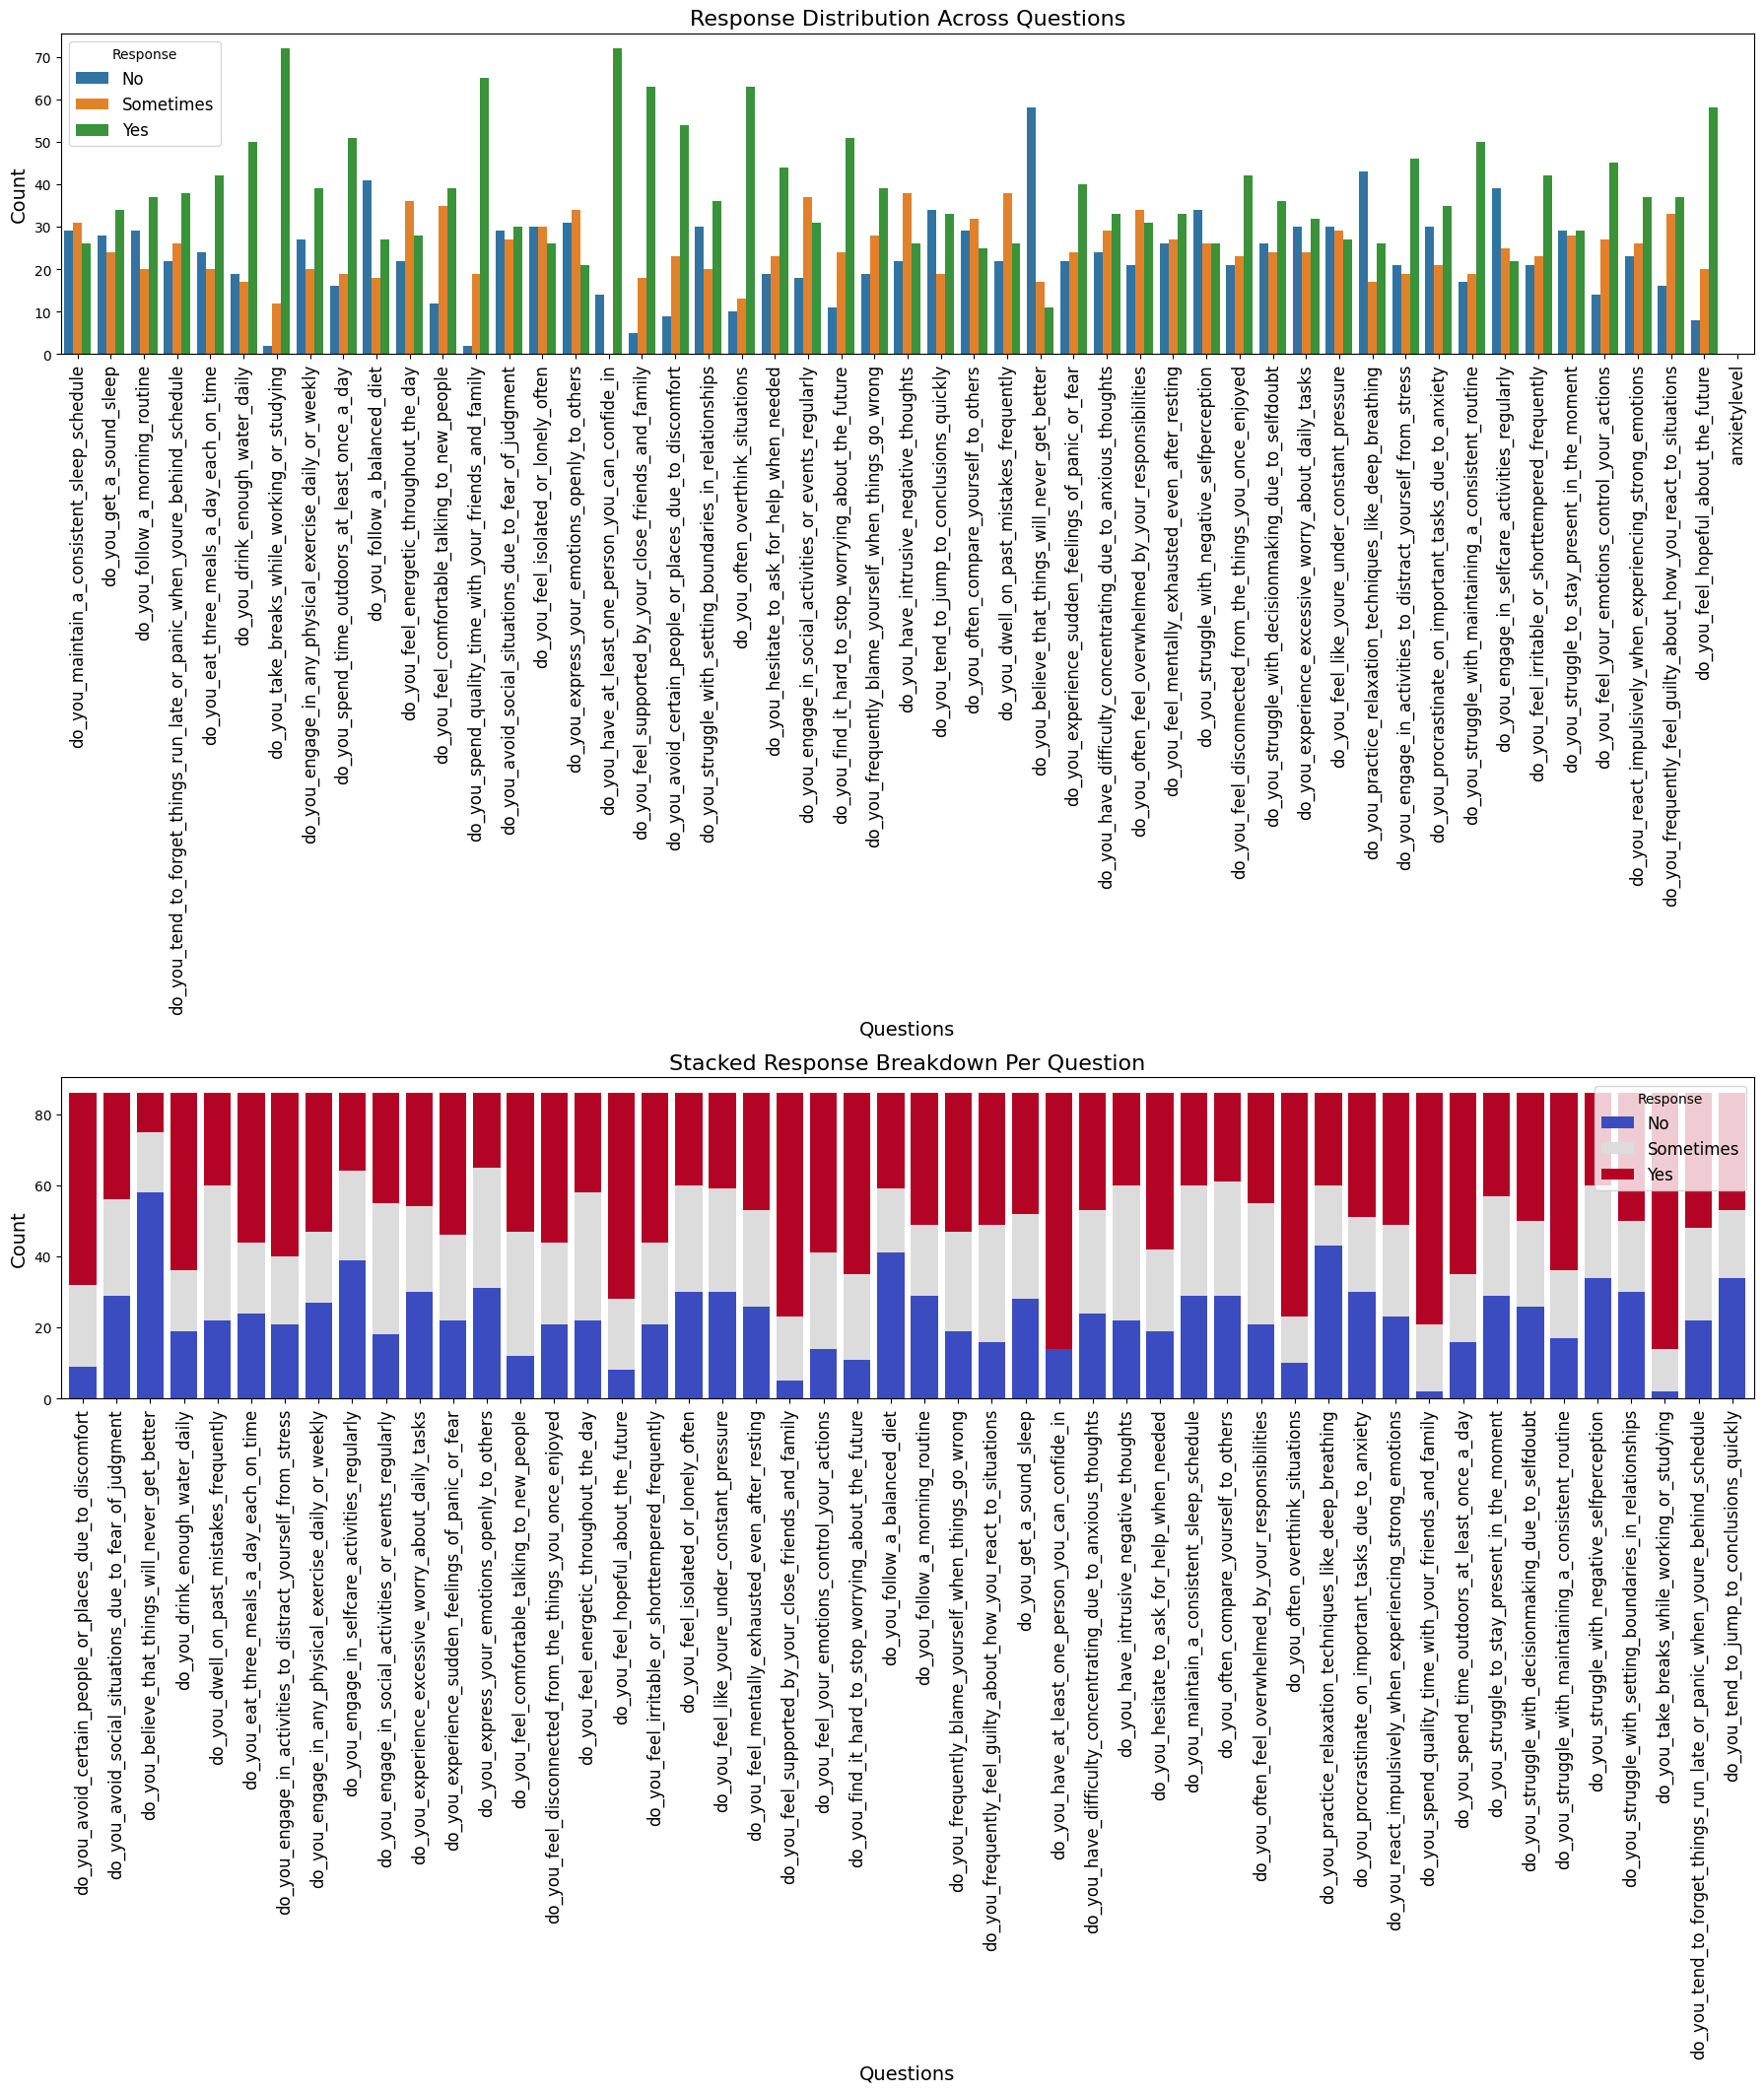

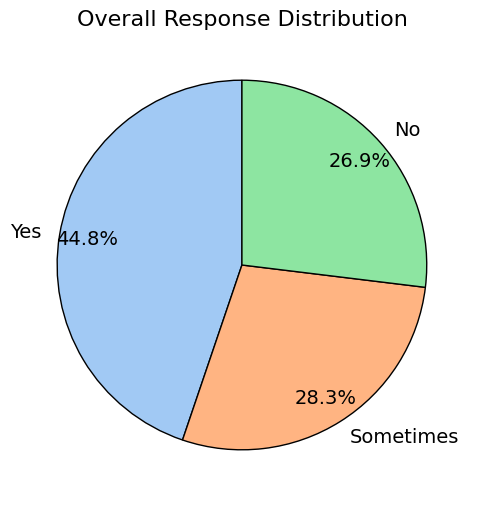

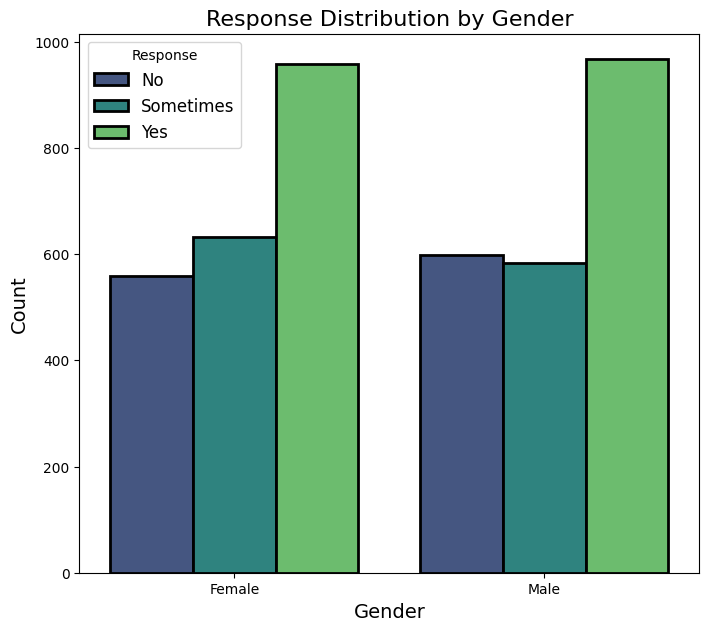

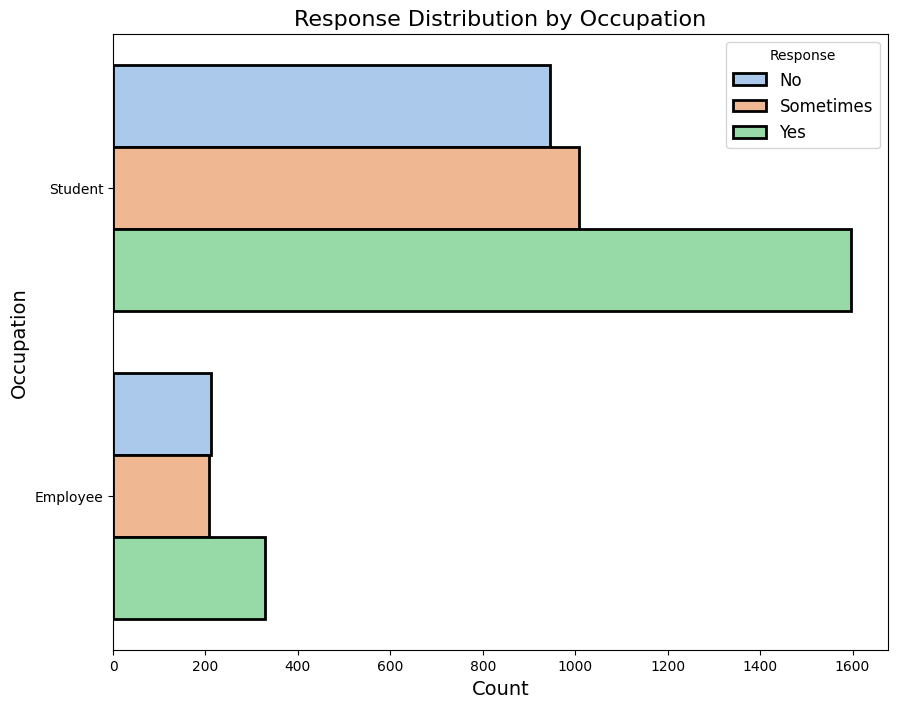


Ready for training model!!!


<ipython-input-203-7206a30bf896>:146: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df[question_cols] = df[question_cols].applymap(lambda x: response_mapping.get(x, x))


In [203]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


# Load the dataset
file_path = '/content/drive/MyDrive/IT/6th sem Project/dataset/atiya_cbt.csv'
df = pd.read_csv(file_path)

# Preprocess column names (remove numbers and special characters)
def clean_column_name(col_name):
    col_name = re.sub(r"^\d+\.\s*", "", col_name)  # Remove leading numbers like "1. "
    col_name = re.sub(r"[^a-zA-Z0-9 ]", "", col_name)  # Remove special characters
    col_name = col_name.strip().lower().replace(" ", "_")  # Convert to lowercase and replace spaces with underscores
    return col_name

df.columns = [clean_column_name(col) for col in df.columns]

# Drop unnecessary columns
columns_to_exclude = ['timestamp', 'name', 'email_address']
df_filtered = df.drop(columns=[col for col in columns_to_exclude if col in df.columns], errors='ignore')

# Fix typo in responses
df_filtered = df_filtered.applymap(lambda x: 'Sometimes' if str(x) == 'Someimes' else x)

# Basic data exploration
print("First 5 rows:\n", df_filtered.head())
print("Last 5 rows:\n", df_filtered.tail())
print("\nShape:", df_filtered.shape)
print("Describe:\n", df_filtered.describe())
print("Info:\n", df_filtered.info())
print("\nMissing values per column:\n", df_filtered.isnull().sum())

df_filtered.drop_duplicates(inplace=True)

for column in df_filtered.columns:
    print(f"Column: {column}")
    print(f"Unique Values: {df_filtered[column].unique()}")
    print(f"Value Counts:\n{df_filtered[column].value_counts()}\n")

# Reshape data for visualization
id_vars = ['age', 'gender', 'occupation']
value_vars = [col for col in df_filtered.columns if col not in id_vars]
df_long = df_filtered.melt(id_vars=id_vars, var_name='question', value_name='response')

# Increase figure size for better readability
plt.figure(figsize=(18, 25))

# 1. Response distribution per question
plt.subplot(3, 1, 1)
sns.countplot(x='question', hue='response', data=df_long, order=df_long['question'].unique())
plt.xticks(rotation=90, fontsize=12)
plt.title("Response Distribution Across Questions", fontsize=16)
plt.xlabel("Questions", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.legend(title="Response", fontsize=12)
print("")

# 2. Stacked response breakdown per question
plt.subplot(3, 1, 2)
df_pivot = df_long.pivot_table(index='question', columns='response', aggfunc='size', fill_value=0)
df_pivot.plot(kind='bar', stacked=True, colormap='coolwarm', width=0.8, ax=plt.gca())
plt.xticks(rotation=90, fontsize=12)
plt.title("Stacked Response Breakdown Per Question", fontsize=16)
plt.xlabel("Questions", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.legend(title="Response", fontsize=12)

plt.tight_layout()
plt.show()
print("")

# 3. Pie char
plt.figure(figsize=(6, 6))
response_counts = df_long['response'].value_counts()
colors = sns.color_palette("pastel", len(response_counts))
plt.pie(response_counts, labels=response_counts.index, autopct='%1.1f%%', colors=colors,
        startangle=90, pctdistance=0.85, wedgeprops={'linewidth': 1, 'edgecolor': 'black'}, textprops={'fontsize': 14})
plt.title("Overall Response Distribution", fontsize=16)
plt.gca().set_aspect('equal')
plt.show()  # Ensure it's a circle
print("")

# 4. Response analysis by gender
plt.figure(figsize=(8, 7))
sns.countplot(x='gender', hue='response', data=df_long, palette='viridis', linewidth=2, edgecolor='black')
plt.title("Response Distribution by Gender", fontsize=16)
plt.xlabel("Gender", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.legend(title="Response", fontsize=12)
plt.show()
print("")

# 5. Response distribution by Occupation
plt.figure(figsize=(10, 8))
sns.countplot(y='occupation', hue='response', data=df_long, palette='pastel', linewidth=2, edgecolor='black')
plt.title("Response Distribution by Occupation", fontsize=16)
plt.xlabel("Count", fontsize=14)
plt.ylabel("Occupation", fontsize=14)
plt.legend(title="Response", fontsize=12)
plt.show()
print("")

# Extract questions (excluding age, gender, occupation)
required_columns = ['age', 'gender', 'occupation']
question_columns = [col for col in df_filtered.columns if col not in required_columns]

# Save extracted questions
question_mapping_df = pd.DataFrame({
    "question_no": [f"Q{i+1}" for i in range(len(question_columns))],
    "question_text": question_columns
})
question_mapping_csv = '/content/drive/MyDrive/Colab Notebooks/question_mapping.csv'
question_mapping_df.to_csv(question_mapping_csv, index=False)

# Replace question text with Q1-Q50
rename_mapping = {question_columns[i]: f"Q{i+1}" for i in range(len(question_columns))}
df_filtered.rename(columns=rename_mapping, inplace=True)

# Save the cleaned dataset
filtered_csv_path = '/content/drive/MyDrive/Colab Notebooks/cbt_user_responses_cleaned.csv'
df_filtered.to_csv(filtered_csv_path, index=False)

# Reload cleaned dataset
df = pd.read_csv(filtered_csv_path)

# Convert categorical values to numerical
age_mapping = {'10-20': 0, '21-40': 1, '41-60': 2, '60+': 3}
df['age'] = df['age'].map(age_mapping)

label_enc = LabelEncoder()
df['gender'] = label_enc.fit_transform(df['gender'])  # Male = 0, Female = 1
df['occupation'] = label_enc.fit_transform(df['occupation'])  # Encoding occupation

# One-Hot Encode Occupation
df = pd.get_dummies(df, columns=['occupation'], drop_first=True)

# Encode survey responses
response_mapping = {'No': 0, 'Sometimes': 1, 'Yes': 2}
question_cols = [col for col in df.columns if col.startswith('Q')]
df[question_cols] = df[question_cols].applymap(lambda x: response_mapping.get(x, x))

# Save final processed dataset
processed_csv_path = '/content/drive/MyDrive/Colab Notebooks/cbt_user_responses_processed.csv'
df.to_csv(processed_csv_path, index=False)

print("Ready for training model!!!")


In [204]:
import pandas as pd

# Load the processed dataset
processed_csv_path = '/content/drive/MyDrive/Colab Notebooks/cbt_user_responses_processed.csv'
df = pd.read_csv(processed_csv_path)

# Define risk and protective factor questions
risk_factors = ["Q4", "Q14", "Q15", "Q19", "Q20", "Q21", "Q22", "Q24", "Q25","Q26", "Q27", "Q28", "Q29", "Q30", "Q31", "Q32", "Q33", "Q34", "Q35","Q36", "Q37", "Q38", "Q39", "Q42", "Q43", "Q45", "Q46", "Q47", "Q48", "Q49"]  # Add actual risk-related questions
protective_factors = ["Q1", "Q2", "Q3", "Q5", "Q6", "Q7", "Q8", "Q9", "Q10", "Q11", "Q12", "Q13", "Q16", "Q17", "Q18", "Q23", "Q40", "Q41", "Q44", "Q50"  ]
# Compute anxiety scores
df['risk_score'] = df[risk_factors].sum(axis=1)
df['protective_score'] = df[protective_factors].sum(axis=1)
df['anxiety_score'] = df['risk_score'] - df['protective_score']

# Define anxiety level categories
def classify_anxiety_level(score):
    if score <= 5:
        return 'Low Anxiety'
    elif 6 <= score <= 12:
        return 'Moderate Anxiety'
    else:
        return 'High Anxiety'

df['anxiety_level'] = df['anxiety_score'].apply(classify_anxiety_level)

# CBT therapy recommendations
def recommend_cbt(level):
    if level == 'Low Anxiety':
        return 'Practice mindfulness, maintain a balanced lifestyle, and engage in self-care routines.'
    elif level == 'Moderate Anxiety':
        return 'Cognitive Behavioral Therapy (CBT) techniques like thought restructuring and relaxation exercises.'
    else:
        return 'Consider professional therapy, exposure therapy, and structured CBT interventions.'

df['cbt_recommendation'] = df['anxiety_level'].apply(recommend_cbt)

# Save results
results_csv_path = '/content/drive/MyDrive/Colab Notebooks/anxiety_levels.csv'
df.to_csv(results_csv_path, index=False)

from google.colab import files

results_csv_path = '/content/drive/MyDrive/Colab Notebooks/anxiety_levels.csv'
# files.download(results_csv_path)
print("Anxiety level detection and CBT recommendations saved!")

df.head()

Anxiety level detection and CBT recommendations saved!


,age,gender,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,...,Q48,Q49,Q50,Q51,occupation_1,risk_score,protective_score,anxiety_score,anxiety_level,cbt_recommendation
0,0,0,0,1,1,2,2,0,2,2,...,2,2,2,NaN,True,52,29,23,High Anxiety,"Consider professional therapy, exposure therap..."
1,1,1,1,2,2,0,2,1,1,2,...,1,0,2,NaN,True,14,31,-17,Low Anxiety,"Practice mindfulness, maintain a balanced life..."
2,0,1,1,1,1,2,2,2,2,0,...,0,1,2,NaN,True,34,28,6,Moderate Anxiety,Cognitive Behavioral Therapy (CBT) techniques ...
3,1,1,2,1,2,1,2,2,2,2,...,1,2,1,NaN,True,42,31,11,Moderate Anxiety,Cognitive Behavioral Therapy (CBT) techniques ...
4,0,0,0,0,0,0,2,2,2,2,...,0,1,2,NaN,True,23,24,-1,Low Anxiety,"Practice mindfulness, maintain a balanced life..."


Files in directory: ['question_mapping.gsheet', 'question_mapping.csv', 'cbt_user_responses_cleaned.csv', 'cbt_user_responses_processed.csv', 'anxiety_levels.csv', 'cbt_user_responses_processed.gsheet', 'final_cbt_analysis.gsheet', 'anxiety_levels_with_cbt_recommendations.csv', 'final_cbt_analysis.csv', 'final_cbt_analysis_with_predictions.csv', 'final_cbt_analysis_with_predictions.gsheet', 'Copy of atiya cbt.ipynb']


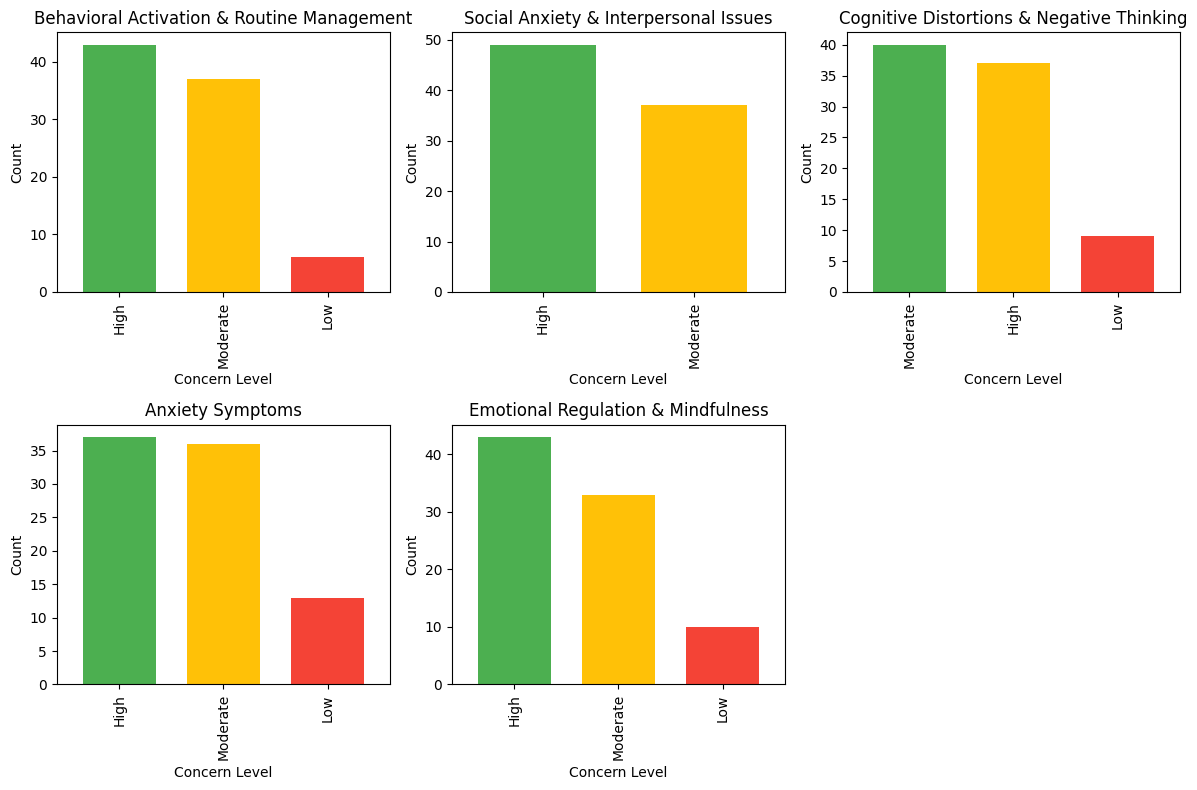

Detailed CBT area-wise analysis and therapy recommendations saved!


In [205]:
import os
file_path = "/content/drive/MyDrive/Colab Notebooks/"
print("Files in directory:", os.listdir(file_path))

import pandas as pd
import matplotlib.pyplot as plt

# Load the processed dataset
processed_csv_path = '/content/drive/MyDrive/Colab Notebooks/cbt_user_responses_processed.csv'
df = pd.read_csv(processed_csv_path)

# Step 1: Mapping questions to 5 concern areas
concern_areas = {
    "Behavioral Activation & Routine Management": ["Q1", "Q2", "Q3", "Q5", "Q6", "Q7", "Q8", "Q9", "Q10", "Q11", "Q43", "Q44"],
    "Social Anxiety & Interpersonal Issues": ["Q12", "Q13", "Q14", "Q15", "Q16", "Q17", "Q18", "Q19", "Q20", "Q22", "Q23"],
    "Cognitive Distortions & Negative Thinking": ["Q21", "Q24", "Q25", "Q26", "Q27", "Q28", "Q29", "Q30", "Q35", "Q37", "Q42", "Q50"],
    "Anxiety Symptoms": ["Q4", "Q31", "Q32", "Q33", "Q34", "Q38", "Q39"],
    "Emotional Regulation & Mindfulness": ["Q40", "Q41", "Q45", "Q46", "Q47", "Q48", "Q49", "Q36"]
}

# Step 2: Score each concern area
for area, questions in concern_areas.items():
    df[area + '_score'] = df[questions].sum(axis=1)

# Step 3: Define thresholds for each area
def classify_concern(score, total_possible):
    if score <= total_possible * 0.25:
        return 'Low'
    elif score <= total_possible * 0.6:
        return 'Moderate'
    else:
        return 'High'

for area, questions in concern_areas.items():
    total_possible = len(questions) * 2  # max score per question = 2
    df[area + '_level'] = df[area + '_score'].apply(lambda x: classify_concern(x, total_possible))

# Step 4: Expand Therapy mapping per concern area
therapy_map = {
    "Behavioral Activation & Routine Management": {
        "High": ["Behavioral Activation Therapy", "Activity Scheduling & Monitoring", "Graded Task Assignment", "Time Management Skills"],
        "Moderate": ["Problem-Solving Therapy", "Habit Reversal Training", "Goal Setting Therapy"],
        "Low": ["Motivation Enhancement", "Values Clarification", "Positive Reinforcement"]
    },
    "Social Anxiety & Interpersonal Issues": {
        "High": ["Exposure Therapy", "Social Skills Training", "Cognitive Behavioral Therapy for Social Anxiety"],
        "Moderate": ["Behavioral Experiments", "Cognitive Restructuring", "Graded Exposure"],
        "Low": ["Assertiveness Practice", "Self-Monitoring", "Relaxation Techniques"]
    },
    "Cognitive Distortions & Negative Thinking": {
        "High": ["Cognitive Restructuring", "Thought Records", "Core Belief Restructuring", "Mindfulness-Based CBT"],
        "Moderate": ["Self-Compassion Training", "Behavioral Experiments", "Challenging Cognitive Distortions"],
        "Low": ["Metacognitive Therapy", "Journaling", "Gratitude Practice"]
    },
    "Anxiety Symptoms": {
        "High": ["Relaxation Techniques", "Exposure Therapy", "Stress Inoculation Training", "Progressive Muscle Relaxation"],
        "Moderate": ["Attention Training Technique", "Habit Reversal Training", "Mindfulness-Based Stress Reduction"],
        "Low": ["Mindfulness", "Breathing Exercises", "Guided Imagery"]
    },
    "Emotional Regulation & Mindfulness": {
        "High": ["Dialectical Behavior Therapy", "Mindfulness-Based Cognitive Therapy (MBCT)", "Distress Tolerance Skills", "ACT (Acceptance and Commitment Therapy)"],
        "Moderate": ["Self-Compassion Training", "ACT", "Mindfulness-Based Practices"],
        "Low": ["Mindfulness-Based Practices", "Values Clarification", "Relaxation Techniques"]
    }
}

# Step 5: Generate therapy recommendations
def recommend_therapies(row):
    recommendations = []
    for area in concern_areas.keys():
        level = row[area + '_level']
        therapies = therapy_map.get(area, {}).get(level, [])
        recommendations.append(f"{area} ({level}): {', '.join(therapies)}")
    return "\n".join(recommendations)

df['therapy_recommendations'] = df.apply(recommend_therapies, axis=1)

# Step 6: Save final results
results_csv_path = '/content/drive/MyDrive/Colab Notebooks/final_cbt_analysis.csv'
df.to_csv(results_csv_path, index=False)

# Visualize concern level distribution
concern_level_counts = {area: df[area + '_level'].value_counts() for area in concern_areas.keys()}

# Plotting distribution of concern levels for each area
plt.figure(figsize=(12, 8))
for i, area in enumerate(concern_areas.keys(), 1):
    plt.subplot(2, 3, i)
    concern_level_counts[area].plot(kind='bar', title=area, color=['#4CAF50', '#FFC107', '#F44336'], width=0.7)
    plt.ylabel('Count')
    plt.xlabel('Concern Level')

plt.tight_layout()
plt.show()

# Print out some of the therapy recommendations
print("Detailed CBT area-wise analysis and therapy recommendations saved!")

# Show sample of the therapy recommendations
df[['therapy_recommendations']].head()

# Step 7: Optional - Collect feedback and update therapy recommendations
# Example: Collect feedback from users and adjust therapy mapping (mock function)
def collect_feedback(user_id, therapy_recommendation, rating):
    feedback_data = {
        'user_id': user_id,
        'therapy_recommendation': therapy_recommendation,
        'rating': rating  # 1-5 scale
    }
    # Store feedback for later processing (e.g., in CSV or database)
    return feedback_data

# Example: Update therapy map based on feedback (mock function)
def update_therapy_map_from_feedback(feedback_df, therapy_map):
    for index, row in feedback_df.iterrows():
        if row['rating'] > 4:  # High rating indicates therapy was effective
            therapy = row['therapy_recommendation']
            # Add or prioritize effective therapies based on feedback
            # Update logic as needed for better recommendations
    return therapy_map


In [206]:
import pandas as pd
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, confusion_matrix
from collections import Counter

df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/final_cbt_analysis.csv")

X = df.loc[:, 'Q1':'Q50']
y = df['Anxiety Symptoms_level']

imputer = SimpleImputer(strategy='mean')
X = imputer.fit_transform(X)

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

clf = RandomForestClassifier(class_weight='balanced', random_state=42)
sss = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)

accuracies, reports, confusion_matrices, low_category_warnings = [], [], [], []
fold = 1
for train_index, test_index in sss.split(X_resampled, y_resampled):
    X_train, X_test = X_resampled[train_index], X_resampled[test_index]
    y_train, y_test = y_resampled[train_index], y_resampled[test_index]

    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    acc = clf.score(X_test, y_test)
    report = classification_report(y_test, y_pred, output_dict=True)
    cm = confusion_matrix(y_test, y_pred)

    accuracies.append(acc)
    reports.append(report)
    confusion_matrices.append(cm)

    try:
        low_recall = report['Low']['recall']
        if low_recall < 0.5:
            low_category_warnings.append(f"⚠️ Fold {fold}: 'Low' category struggling (Recall: {low_recall:.2f})")
    except KeyError:
        low_category_warnings.append(f"⚠️ Fold {fold}: 'Low' category missing in predictions.")

    print(f"\n🟦 Fold {fold} Confusion Matrix:\n{cm}")
    fold += 1

avg_acc = sum(accuracies) / len(accuracies)
print(f"\n🟢 Average Accuracy: {avg_acc:.2f}")
print(f"\n🟠 Confusion Matrices: {confusion_matrices}")
print(f"\n🔵 Detailed Classification Reports: {reports}")

if low_category_warnings:
    print("\n⚠️ Low Category Struggling in Some Folds:")
    for warning in low_category_warnings:
        print(warning)
else:
    print("\n🟢 No issues with the 'Low' category.")



🟦 Fold 1 Confusion Matrix:
[[7 0 0]
 [0 6 2]
 [0 1 7]]

🟦 Fold 2 Confusion Matrix:
[[8 0 0]
 [0 8 0]
 [1 0 6]]

🟦 Fold 3 Confusion Matrix:
[[8 0 0]
 [0 8 0]
 [0 0 7]]

🟦 Fold 4 Confusion Matrix:
[[5 0 2]
 [0 6 2]
 [1 0 7]]

🟦 Fold 5 Confusion Matrix:
[[7 0 0]
 [0 8 0]
 [0 0 8]]

🟢 Average Accuracy: 0.92

🟠 Confusion Matrices: [array([[7, 0, 0],
       [0, 6, 2],
       [0, 1, 7]]), array([[8, 0, 0],
       [0, 8, 0],
       [1, 0, 6]]), array([[8, 0, 0],
       [0, 8, 0],
       [0, 0, 7]]), array([[5, 0, 2],
       [0, 6, 2],
       [1, 0, 7]]), array([[7, 0, 0],
       [0, 8, 0],
       [0, 0, 8]])]

🔵 Detailed Classification Reports: [{'High': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 7.0}, 'Low': {'precision': 0.8571428571428571, 'recall': 0.75, 'f1-score': 0.8, 'support': 8.0}, 'Moderate': {'precision': 0.7777777777777778, 'recall': 0.875, 'f1-score': 0.8235294117647058, 'support': 8.0}, 'accuracy': 0.8695652173913043, 'macro avg': {'precision': 0.878306878306

In [207]:
import pandas as pd
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, confusion_matrix

# Load the dataset
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/final_cbt_analysis.csv")

# Prepare the feature set (Q1 to Q50) and target variables for each concern area
X = df.loc[:, 'Q1':'Q50']

# Function to train, predict, and retrieve therapy recommendations
def train_and_predict(X, y, concern_area):
    smote = SMOTE(random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X, y)

    # Convert X_resampled back to DataFrame to preserve columns
    X_resampled = pd.DataFrame(X_resampled, columns=X.columns)

    clf = RandomForestClassifier(class_weight='balanced', random_state=42)
    sss = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)

    predictions = []
    for train_index, test_index in sss.split(X_resampled, y_resampled):
        X_train, X_test = X_resampled.iloc[train_index], X_resampled.iloc[test_index]
        y_train, y_test = y_resampled[train_index], y_resampled[test_index]

        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)

        predictions.extend(y_pred)

    # Make sure predictions length matches the number of samples
    return predictions

# Define the concern areas and corresponding columns
concern_areas = {
    'Behavioral Activation & Routine Management': 'Behavioral Activation & Routine Management_level',
    'Social Anxiety & Interpersonal Issues': 'Social Anxiety & Interpersonal Issues_level',
    'Cognitive Distortions & Negative Thinking': 'Cognitive Distortions & Negative Thinking_level',
    'Anxiety Symptoms': 'Anxiety Symptoms_level',
    'Emotional Regulation & Mindfulness': 'Emotional Regulation & Mindfulness_level'
}

# Train models and predict levels for each concern area
predictions = {}
for concern, target_column in concern_areas.items():
    target = df[target_column]
    predictions[concern] = train_and_predict(X, target, concern)

# Ensure all predictions arrays have the same length
max_len = max(len(pred) for pred in predictions.values())
for concern in predictions:
    pred_len = len(predictions[concern])
    if pred_len < max_len:
        predictions[concern] = predictions[concern] + [None] * (max_len - pred_len)  # Padding

# Create a DataFrame of predicted levels for each concern area
predicted_df = pd.DataFrame(predictions)

# Function to get therapy recommendations
def get_therapy_recommendation(row):
    recommendations = []

    # Loop over each concern area and retrieve the corresponding therapy recommendation
    for concern in concern_areas.keys():
        level = row[concern]

        # Check if there's a matching therapy recommendation
        if pd.isna(level):  # If there's no level, handle gracefully
            recommendations.append(f"{concern} (No Level): No recommendation found")
        else:
            matching_rows = df.loc[df[concern_areas[concern]] == level, 'therapy_recommendations']

            if not matching_rows.empty:
                therapy_recommendation = matching_rows.values[0]
                recommendations.append(f"{concern} ({level}): {therapy_recommendation}")
            else:
                recommendations.append(f"{concern} ({level}): No recommendation found")

    # Combine all recommendations into a single string
    return " | ".join(recommendations)

# Apply the function to get therapy recommendations for each row
predicted_df['therapy_recommendations'] = predicted_df.apply(get_therapy_recommendation, axis=1)


In [208]:
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from collections import Counter

# Step 1: Handle Class Imbalance using SMOTE
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print(f"Before SMOTE: {Counter(y_train)}")
print(f"After SMOTE: {Counter(y_train_resampled)}")

# Step 2: Use Random Forest Classifier and Hyperparameter Tuning
rf = RandomForestClassifier(random_state=42)

# Set up the parameter grid for tuning
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Perform GridSearchCV with Cross-Validation
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X_train_resampled, y_train_resampled)

# Best Parameters and Model
best_rf_model = grid_search.best_estimator_
print(f"Best Parameters: {grid_search.best_params_}")

# Step 3: Evaluate the Model
y_pred = best_rf_model.predict(X_test)  # Assuming you have X_test and y_test
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))


from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
from collections import Counter
import pandas as pd

def train_and_evaluate_model(X, y, category_name="CBT Category"):
    # Step 1: Train-Test Split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    # Step 2: SMOTE to handle imbalance
    print(f"\nBefore SMOTE: {Counter(y_train)}")
    smote = SMOTE(random_state=42)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
    print(f"After SMOTE: {Counter(y_train_resampled)}")

    # Step 3: Hyperparameter Grid for Random Forest
    param_grid = {
        'n_estimators': [100, 200, 300],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1, 2],
        'bootstrap': [True, False]
    }

    rf = RandomForestClassifier(random_state=42)
    grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, verbose=1, n_jobs=-1)
    grid_search.fit(X_train_resampled, y_train_resampled)

    # Step 4: Best Model
    best_rf = grid_search.best_estimator_
    print(f"\nBest Parameters for {category_name}: {grid_search.best_params_}")

    # Step 5: Prediction and Evaluation
    y_pred = best_rf.predict(X_test)
    print(f"\nClassification Report for {category_name}:\n{classification_report(y_test, y_pred)}")
    print(f"Confusion Matrix for {category_name}:\n{confusion_matrix(y_test, y_pred)}")

    return best_rf


Before SMOTE: Counter({'High': 30, 'Low': 29, 'Moderate': 29})
After SMOTE: Counter({'Low': 30, 'Moderate': 30, 'High': 30})
Fitting 3 folds for each of 216 candidates, totalling 648 fits


KeyboardInterrupt: 

In [214]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
from collections import Counter

def train_and_evaluate_model(X, y, category_name="CBT Category"):
    # Step 1: Train-Test Split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    # Step 2: Handle Class Imbalance using SMOTE
    print(f"\n📊 Before SMOTE: {Counter(y_train)}")
    smote = SMOTE(sampling_strategy='auto', random_state=42)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
    print(f"✅ After SMOTE: {Counter(y_train_resampled)}")

    # Step 3: Random Forest with Hyperparameter Tuning
    param_grid = {
        'n_estimators': [100, 200, 300],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'bootstrap': [True, False]
    }

    rf = RandomForestClassifier(random_state=42)
    grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
    grid_search.fit(X_train_resampled, y_train_resampled)

    best_rf_model = grid_search.best_estimator_
    print(f"\n🥇 Best Parameters for {category_name}: {grid_search.best_params_}")

    # Step 4: Model Evaluation
    y_pred = best_rf_model.predict(X_test)
    print(f"\n📋 Classification Report for {category_name}:\n{classification_report(y_test, y_pred)}")
    print(f"🧮 Confusion Matrix for {category_name}:\n{confusion_matrix(y_test, y_pred)}")

    return best_rf_model


In [215]:
# Example call (replace X and y with your actual feature matrix and target vector)
trained_model = train_and_evaluate_model(X, y, category_name="Anxiety Severity")



📊 Before SMOTE: Counter({np.int64(2): 34, np.int64(1): 29, np.int64(0): 5})


ValueError: Expected n_neighbors <= n_samples_fit, but n_neighbors = 6, n_samples_fit = 5, n_samples = 5

In [216]:
import pandas as pd

# Assuming your dataset is loaded into a pandas DataFrame
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/final_cbt_analysis.csv")  # Replace with your actual dataset file

# Define the feature columns (Q1 to Q50, age, gender, occupation_1)
feature_columns = [f'Q{i}' for i in range(1, 51)] + ['age', 'gender', 'occupation_1']

# Extract features (X)
X_ba = df[feature_columns].values  # Behavioral Activation features
X_sa = df[feature_columns].values  # Social Anxiety features
X_cd = df[feature_columns].values  # Cognitive Distortions features
X_as = df[feature_columns].values  # Anxiety Symptoms features
X_er = df[feature_columns].values  # Emotional Regulation features

# Extract labels (y) for each category
y_ba = df['Behavioral Activation & Routine Management_level'].map({
    'Low': 0, 'Moderate': 1, 'High': 2
}).values

y_sa = df['Social Anxiety & Interpersonal Issues_level'].map({
    'Low': 0, 'Moderate': 1, 'High': 2
}).values

y_cd = df['Cognitive Distortions & Negative Thinking_level'].map({
    'Low': 0, 'Moderate': 1, 'High': 2
}).values

y_as = df['Anxiety Symptoms_level'].map({
    'Low': 0, 'Moderate': 1, 'High': 2
}).values

y_er = df['Emotional Regulation & Mindfulness_level'].map({
    'Low': 0, 'Moderate': 1, 'High': 2
}).values

# Now you can build your datasets dictionary
datasets_dict = {
    "Behavioral Activation": {"X": X_ba, "y": y_ba},
    "Social Anxiety": {"X": X_sa, "y": y_sa},
    "Cognitive Distortions": {"X": X_cd, "y": y_cd},
    "Anxiety Symptoms": {"X": X_as, "y": y_as},
    "Emotional Regulation": {"X": X_er, "y": y_er},
}
models = {}
for category, data in datasets_dict.items():
    X, y = data['X'], data['y']
    print(f"\nTraining model for {category}...")
    best_model = train_and_evaluate_model(X, y, category)
    models[category] = best_model

# Sample user response for predictions (replace this with actual responses)
user_responses = [1, 0, 2, 1, 0, 1, 2, 0, 1, 1, 0, 1, 2, 0]  # Example user responses
predictions = {}
for category, model in models.items():
    predictions[category] = model.predict([user_responses])[0]

# Define therapy mapping based on severity levels
therapy_mapping = {
    "Behavioral Activation": {
        "High": ["Behavioral Activation", "Activity Scheduling", "Goal Setting"],
        "Moderate": ["Motivational Interviewing", "Routine Enhancement"],
        "Low": ["Daily Monitoring", "Reward Tracking"]
    },
    # Add mappings for other categories similarly
}

# Example of severity prediction (replace with actual prediction logic)
severity_predictions = {
    "Behavioral Activation": "High",
    "Social Anxiety": "Moderate",
    # Other predictions here
}

# Map severity to therapy recommendations
recommendations = {}
for category, severity in severity_predictions.items():
    recommendations[category] = therapy_mapping[category][severity]

# Output therapy recommendations
print("\nTherapy Recommendations:")
for category, therapy_list in recommendations.items():
    print(f"{category}: {', '.join(therapy_list)}")



Training model for Behavioral Activation...

📊 Before SMOTE: Counter({np.int64(2): 34, np.int64(1): 29, np.int64(0): 5})


ValueError: Expected n_neighbors <= n_samples_fit, but n_neighbors = 6, n_samples_fit = 5, n_samples = 5

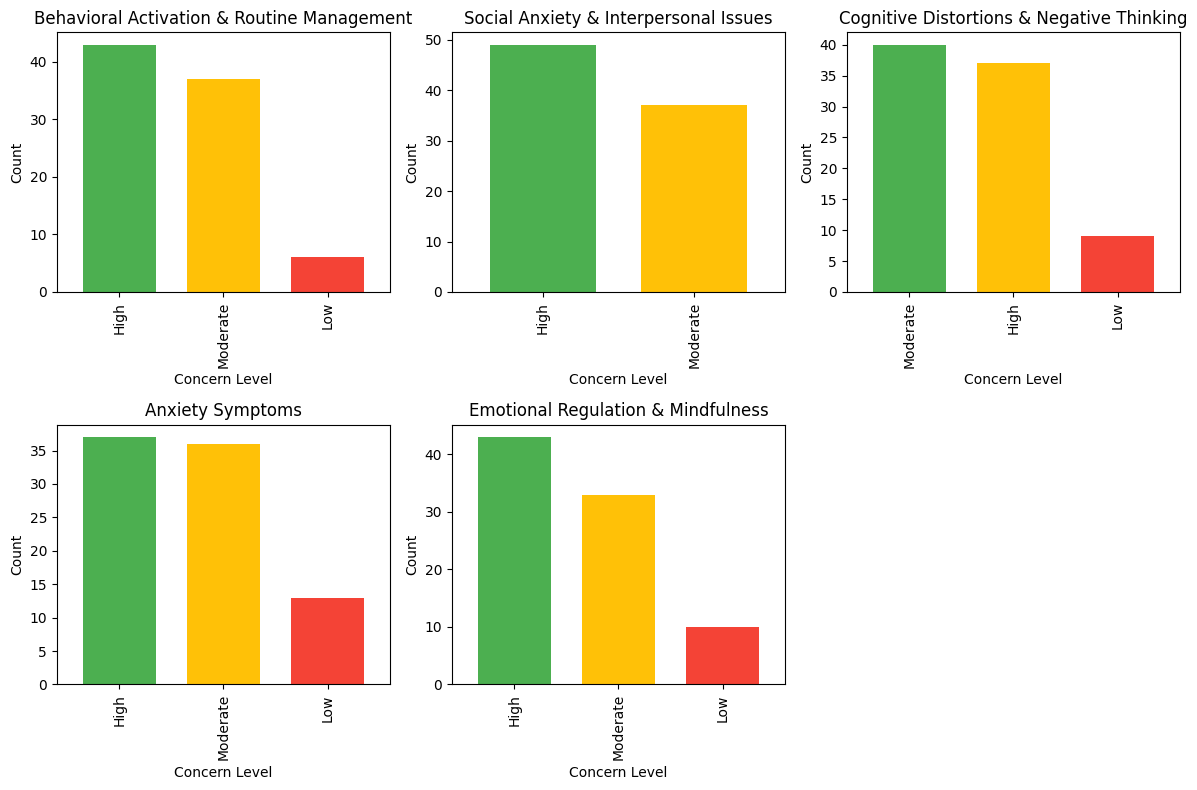

Detailed CBT area-wise analysis and therapy recommendations saved!
                             therapy_recommendations     anxiety_level  \
0  Behavioral Activation & Routine Management (Hi...      High Anxiety   
1  Behavioral Activation & Routine Management (Hi...       Low Anxiety   
2  Behavioral Activation & Routine Management (Hi...  Moderate Anxiety   
3  Behavioral Activation & Routine Management (Hi...  Moderate Anxiety   
4  Behavioral Activation & Routine Management (Mo...       Low Anxiety   

                                  cbt_recommendation  
0  Consider professional therapy, exposure therap...  
1  Practice mindfulness, maintain a balanced life...  
2  Cognitive Behavioral Therapy (CBT) techniques ...  
3  Cognitive Behavioral Therapy (CBT) techniques ...  
4  Practice mindfulness, maintain a balanced life...  


In [217]:
#3333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333

import pandas as pd
import matplotlib.pyplot as plt

# Load the processed dataset
processed_csv_path = '/content/drive/MyDrive/Colab Notebooks/cbt_user_responses_processed.csv'
df = pd.read_csv(processed_csv_path)

# Step 1: Mapping questions to 5 concern areas
concern_areas = {
    "Behavioral Activation & Routine Management": ["Q1", "Q2", "Q3", "Q5", "Q6", "Q7", "Q8", "Q9", "Q10", "Q11", "Q43", "Q44"],
    "Social Anxiety & Interpersonal Issues": ["Q12", "Q13", "Q14", "Q15", "Q16", "Q17", "Q18", "Q19", "Q20", "Q22", "Q23"],
    "Cognitive Distortions & Negative Thinking": ["Q21", "Q24", "Q25", "Q26", "Q27", "Q28", "Q29", "Q30", "Q35", "Q37", "Q42", "Q50"],
    "Anxiety Symptoms": ["Q4", "Q31", "Q32", "Q33", "Q34", "Q38", "Q39"],
    "Emotional Regulation & Mindfulness": ["Q40", "Q41", "Q45", "Q46", "Q47", "Q48", "Q49", "Q36"]
}

# Step 2: Score each concern area
for area, questions in concern_areas.items():
    df[area + '_score'] = df[questions].sum(axis=1)

# Step 3: Define thresholds for each area
def classify_concern(score, total_possible):
    if score <= total_possible * 0.25:
        return 'Low'
    elif score <= total_possible * 0.6:
        return 'Moderate'
    else:
        return 'High'

for area, questions in concern_areas.items():
    total_possible = len(questions) * 2  # max score per question = 2
    df[area + '_level'] = df[area + '_score'].apply(lambda x: classify_concern(x, total_possible))

# Step 4: Expand Therapy mapping per concern area
therapy_map = {
  "Behavioral Activation & Routine Management": {
    "High": [
      "Behavioral Activation Therapy",
      "Activity Scheduling & Monitoring",
      "Graded Task Assignment",
      "Time Management Skills",
      "Sleep Hygiene Training",
      "Routine Planning Worksheets",
      "Daily Energy Tracking"
    ],
    "Moderate": [
      "Problem-Solving Therapy",
      "Habit Reversal Training",
      "Goal Setting Therapy",
      "Implementation Intentions",
      "Behavioral Experiment Logs"
    ],
    "Low": [
      "Motivation Enhancement",
      "Values Clarification",
      "Positive Reinforcement",
      "Weekly Planning Sessions",
      "Reward Tracking Charts"
    ]
  },
  "Social Anxiety & Interpersonal Issues": {
    "High": [
      "Exposure Therapy",
      "Social Skills Training",
      "Cognitive Behavioral Therapy for Social Anxiety",
      "Role Play Exercises",
      "Shame-Attacking Exercises",
      "Assertiveness Training Groups"
    ],
    "Moderate": [
      "Behavioral Experiments",
      "Cognitive Restructuring",
      "Graded Exposure",
      "Video Feedback for Social Interactions",
      "Social Confidence Building Worksheets"
    ],
    "Low": [
      "Assertiveness Practice",
      "Self-Monitoring",
      "Relaxation Techniques",
      "Self-Disclosure Exercises",
      "Friendship-Building Activities"
    ]
  },
  "Cognitive Distortions & Negative Thinking": {
    "High": [
      "Cognitive Restructuring",
      "Thought Records",
      "Core Belief Restructuring",
      "Mindfulness-Based CBT",
      "Downward Arrow Technique",
      "Socratic Questioning",
      "Cognitive Defusion Techniques"
    ],
    "Moderate": [
      "Self-Compassion Training",
      "Behavioral Experiments",
      "Challenging Cognitive Distortions",
      "Positive Data Logs",
      "Cognitive Rescripting"
    ],
    "Low": [
      "Metacognitive Therapy",
      "Journaling",
      "Gratitude Practice",
      "Reframing Exercises",
      "Daily Positivity Logs"
    ]
  },
  "Anxiety Symptoms": {
    "High": [
      "Relaxation Techniques",
      "Exposure Therapy",
      "Stress Inoculation Training",
      "Progressive Muscle Relaxation",
      "Worry Time Scheduling",
      "Anxiety Hierarchies",
      "Interoceptive Exposure"
    ],
    "Moderate": [
      "Attention Training Technique",
      "Habit Reversal Training",
      "Mindfulness-Based Stress Reduction",
      "Safe Space Visualization",
      "Coping Skills Rehearsal"
    ],
    "Low": [
      "Mindfulness",
      "Breathing Exercises",
      "Guided Imagery",
      "Daily Stress Logs",
      "Grounding Techniques"
    ]
  },
  "Emotional Regulation & Mindfulness": {
    "High": [
      "Dialectical Behavior Therapy",
      "Mindfulness-Based Cognitive Therapy (MBCT)",
      "Distress Tolerance Skills",
      "ACT (Acceptance and Commitment Therapy)",
      "Emotion Regulation Training",
      "STOPP Technique",
      "Opposite Action Strategy"
    ],
    "Moderate": [
      "Self-Compassion Training",
      "ACT",
      "Mindfulness-Based Practices",
      "Emotion Labeling Exercises",
      "Urge Surfing Techniques"
    ],
    "Low": [
      "Mindfulness-Based Practices",
      "Values Clarification",
      "Relaxation Techniques",
      "Five Senses Grounding",
      "Gratitude Meditation"
    ]
  }
}

# Step 5: Generate therapy recommendations based on concern area levels
def recommend_therapies(row):
    recommendations = []
    for area in concern_areas.keys():
        level = row[area + '_level']
        therapies = therapy_map.get(area, {}).get(level, [])
        recommendations.append(f"{area} ({level}): {', '.join(therapies)}")
    return "\n".join(recommendations)

df['therapy_recommendations'] = df.apply(recommend_therapies, axis=1)

# Step 6: Save final results
final_results_csv_path = '/content/drive/MyDrive/Colab Notebooks/final_cbt_analysis.csv'
df.to_csv(final_results_csv_path, index=False)

# Visualize concern level distribution
concern_level_counts = {area: df[area + '_level'].value_counts() for area in concern_areas.keys()}

# Plotting distribution of concern levels for each area
plt.figure(figsize=(12, 8))
for i, area in enumerate(concern_areas.keys(), 1):
    plt.subplot(2, 3, i)
    concern_level_counts[area].plot(kind='bar', title=area, color=['#4CAF50', '#FFC107', '#F44336'], width=0.7)
    plt.ylabel('Count')
    plt.xlabel('Concern Level')

plt.tight_layout()
plt.show()

# Step 7: Compute anxiety scores and CBT recommendations based on risk and protective factors
# Define risk and protective factor questions
risk_factors = ["Q4", "Q14", "Q15", "Q19", "Q20", "Q21", "Q22", "Q24", "Q25", "Q26", "Q27", "Q28", "Q29", "Q30", "Q31", "Q32", "Q33", "Q34", "Q35", "Q36", "Q37", "Q38", "Q39", "Q42", "Q43", "Q45", "Q46", "Q47", "Q48", "Q49"]
protective_factors = ["Q1", "Q2", "Q3", "Q5", "Q6", "Q7", "Q8", "Q9", "Q10", "Q11", "Q12", "Q13", "Q16", "Q17", "Q18", "Q23", "Q40", "Q41", "Q44", "Q50"]

# Compute anxiety scores
df['risk_score'] = df[risk_factors].sum(axis=1)
df['protective_score'] = df[protective_factors].sum(axis=1)
df['anxiety_score'] = df['risk_score'] - df['protective_score']

# Define anxiety level categories
def classify_anxiety_level(score):
    if score <= 5:
        return 'Low Anxiety'
    elif 6 <= score <= 12:
        return 'Moderate Anxiety'
    else:
        return 'High Anxiety'

df['anxiety_level'] = df['anxiety_score'].apply(classify_anxiety_level)

# CBT therapy recommendations based on anxiety level
def recommend_cbt(level):
    if level == 'Low Anxiety':
        return 'Practice mindfulness, maintain a balanced lifestyle, and engage in self-care routines.'
    elif level == 'Moderate Anxiety':
        return 'Cognitive Behavioral Therapy (CBT) techniques like thought restructuring and relaxation exercises.'
    else:
        return 'Consider professional therapy, exposure therapy, and structured CBT interventions.'

df['cbt_recommendation'] = df['anxiety_level'].apply(recommend_cbt)

# Save final results with anxiety-level recommendations
final_results_csv_path = '/content/drive/MyDrive/Colab Notebooks/anxiety_levels_with_cbt_recommendations.csv'
df.to_csv(final_results_csv_path, index=False)

# Print out some of the therapy recommendations and anxiety-level results
print("Detailed CBT area-wise analysis and therapy recommendations saved!")
print(df[['therapy_recommendations', 'anxiety_level', 'cbt_recommendation']].head())


In [218]:
# Importing necessary libraries
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder

# Encode the target variable y_train and y_test
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Step 1: Train the Random Forest Classifier
model = RandomForestClassifier(n_estimators=100, random_state=42)  # 100 trees in the forest
model.fit(X_train, y_train_encoded)  # Train the model with encoded y_train

# Step 2: Make predictions on the test set
y_pred = model.predict(X_test)

# Step 3: Evaluate the model's performance
accuracy = accuracy_score(y_test_encoded, y_pred)
print(f'Accuracy: {accuracy * 100:.2f}%')

# Detailed classification report for further evaluation
print(classification_report(y_test_encoded, y_pred))


Accuracy: 95.65%
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       1.00      0.88      0.93         8
           2       0.89      1.00      0.94         8

    accuracy                           0.96        23
   macro avg       0.96      0.96      0.96        23
weighted avg       0.96      0.96      0.96        23



In [219]:
# Select only the numeric columns from the dataframe
df_numeric = df.select_dtypes(include=['number'])
df_numeric = df_numeric.drop(columns=['Q51'], errors='ignore')
print(df_numeric.head())

   age  gender  Q1  Q2  Q3  Q4  Q5  Q6  Q7  Q8  ...  Q49  Q50  \
0    0       0   0   1   1   2   2   0   2   2  ...    2    2   
1    1       1   1   2   2   0   2   1   1   2  ...    0    2   
2    0       1   1   1   1   2   2   2   2   0  ...    1    2   
3    1       1   2   1   2   1   2   2   2   2  ...    2    1   
4    0       0   0   0   0   0   2   2   2   2  ...    1    2   

   Behavioral Activation & Routine Management_score  \
0                                                16   
1                                                17   
2                                                18   
3                                                21   
4                                                13   

   Social Anxiety & Interpersonal Issues_score  \
0                                           17   
1                                           12   
2                                           13   
3                                           14   
4                           

Accuracy: 0.9444

Classification Report:
               precision    recall  f1-score   support

        High       1.00      1.00      1.00         6
         Low       0.67      1.00      0.80         2
    Moderate       1.00      0.90      0.95        10

    accuracy                           0.94        18
   macro avg       0.89      0.97      0.92        18
weighted avg       0.96      0.94      0.95        18



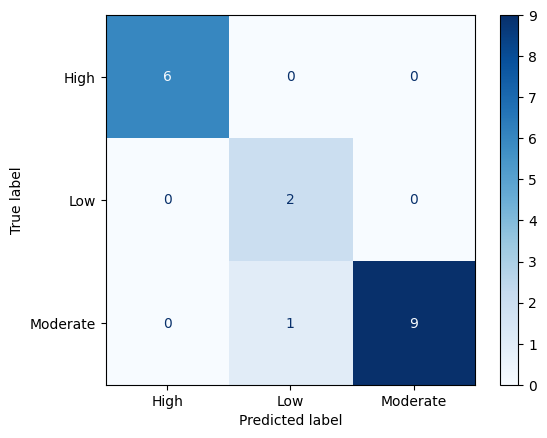

In [220]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt

# Convert score to anxiety level
def get_level(score):
    if score <= 5:
        return 'Low'
    elif score <= 10:
        return 'Moderate'
    else:
        return 'High'

df_numeric = df_numeric.drop(columns=['Q51'], errors='ignore')  # 🔧 Drop unwanted column
df_numeric['Anxiety_Level'] = df_numeric['Anxiety Symptoms_score'].apply(get_level)

# Define features and target
X = df_numeric.drop(columns=['Anxiety_Level'])
y = df_numeric['Anxiety_Level']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Train model
model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
model.fit(X_train_resampled, y_train_resampled)

# Predict and evaluate
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}\n")
print("Classification Report:\n", classification_report(y_test, y_pred))

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(conf_matrix, display_labels=model.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.show()


In [221]:
# Sample new input for prediction
new_input = pd.DataFrame({
    'age': [30],
    'gender': [1],  # Assuming 0 = male, 1 = female
    'Q1': [0],
    'Q2': [0],
    'Q3': [0],
    'Q4': [2],
    'Q5': [0],
    'Q6': [0],
    'Q7': [0],
    'Q8': [0],
    'Q9': [0],
    'Q10': [0],
    'Q11': [0],
    'Q12': [0],
    'Q13': [0],
    'Q14': [2],
    'Q15': [2],
    'Q16': [0],
    'Q17': [0],
    'Q18': [0],
    'Q19': [2],
    'Q20': [2],
    'Q21': [2],
    'Q22': [2],
    'Q23': [0],
    'Q24': [2],
    'Q25': [2],
    'Q26': [2],
    'Q27': [2],
    'Q28': [2],
    'Q29': [2],
    'Q30': [2],
    'Q31': [2],
    'Q32': [2],
    'Q33': [2],
    'Q34': [2],
    'Q35': [2],
    'Q36': [2],
    'Q37': [2],
    'Q38': [2],
    'Q39': [2],
    'Q40': [0],
    'Q41': [0],
    'Q42': [2],
    'Q43': [2],
    'Q44': [0],
    'Q45': [2],
    'Q46': [2],
    'Q47': [2],
    'Q48': [2],
    'Q49': [2],
    'Q50': [0],
    'Behavioral Activation & Routine Management_score': [1],
    'Social Anxiety & Interpersonal Issues_score': [2],
    'Cognitive Distortions & Negative Thinking_score': [1],
    'Anxiety Symptoms_score': [1],
    'Emotional Regulation & Mindfulness_score': [0],
    'risk_score': [20],
    'protective_score': [15],
    'anxiety_score': [5]
})

# Ensure columns in 'new_input' match those in the model's training data
new_input = new_input[model.feature_names_in_]

# Predict anxiety level
predicted_level = model.predict(new_input)

# Get therapy recommendations
predicted_therapy = recommend_therapy(predicted_level[0])

# Display results
print(f"Predicted Anxiety Level: {predicted_level[0]}")
print(f"Recommended Therapy: {predicted_therapy}")


Predicted Anxiety Level: Low
Recommended Therapy: Mindfulness, Breathing Exercises
